In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Mar 27 11:41:46 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 27 11:41:46 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

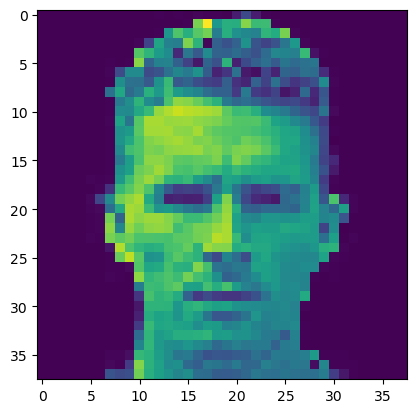

In [3]:
plt.imshow(X)

In [4]:
Y = np.fft.fft2(X)

In [5]:
width, height = Y.shape

In [23]:
n = 2
yul = Y[:n, :n]
yur = Y[:n, n:]
yll = Y[n:, :n]
ylr = Y[n:, n:]

Z = np.block([[yul, yur],
              [yll, ylr]])
Z.shape

(38, 38)

In [28]:
z = Z.flatten()
z = z.reshape((-1, 1))
z.shape

(1444, 1)

In [29]:
A = np.random.randint(0,2,size=(z.shape[0],4*n**2))
A.shape

(1444, 16)

In [30]:
b = A@z.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 16)